<a href="https://colab.research.google.com/github/2019mohamed/ArabDialectClassification/blob/master/PassiveAggressive_MLP_Online_fair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/two_clo_dialect_dataset.csv')
df

,new_text,label
0,بالنهايه ينتفض يغير,0
1,يعني محسوب البشر حيونه ووحشيه وتطلبون الغرب يح...,0
2,مبين كلامه خليجي,0
3,يسلملي مرورك وروحك الحلوه,0
4,وين الغيبه اخ محمد,0
...,...,...
458192,مبسوطين منك اللي باسطانا,17
458193,والله ماينده ابش يختي,17
458194,شو عملنا حنا تهربي مننا احنا مساكين ليش بتعملي...,17
458195,الله يبارك وبالعافيه,17


In [ ]:
df['label'].value_counts().min()

9246

In [ ]:
corpus = df['new_text'].astype('str').tolist()
labels = df['label'].tolist()

In [ ]:
def get_index ():
  freqs = df['label'].value_counts()

  start = [0 for _ in range(18)]
  start[0] = 0
  for c in range(1,18):
      start[c] += freqs[c-1] + start[c-1]  
  indexes = []# (mini , maxi+1) for all classes
  for c in range(18):
      indexes.append(  (start[c] , start[c] + freqs[c]) )
    
  return indexes

In [ ]:
import numpy as np
def sample_data (data , label ,intervals, lim = 1000):
  data = np.array(data)
  label = np.array(label)
  ret = np.array([])
  retl = np.array([])
  for i in range(18):
    l = intervals[i][0]
    h = intervals[i][1]


    index = np.random.choice(range(l,h), size = lim , replace = False)


    ret = np.concatenate((ret , data[index]), axis = 0)
    retl = np.concatenate((retl , label[index]), axis = 0)

  return ret,retl

In [29]:
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
vec = pickle.load(open('/content/drive/MyDrive/vectorizer.pkl', 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [ ]:
indexes = get_index()

In [30]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler , BatchSampler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from scipy.sparse import coo_matrix

In [31]:
class MLP(nn.Module):
    """MLP with linear output"""
    def __init__(self, num_layers, input_dim, hidden_dim, output_dim):
        """MLP layers construction
        Paramters
        ---------
        num_layers: int
            The number of linear layers
        input_dim: int
            The dimensionality of input features
        hidden_dim: int
            The dimensionality of hidden units at ALL layers
        output_dim: int
            The number of classes for prediction
        """
        super(MLP, self).__init__()
        self.linear_or_not = True  # default is linear model
        self.num_layers = num_layers
        self.output_dim = output_dim

        if num_layers < 1:
            raise ValueError("number of layers should be positive!")
        elif num_layers == 1:
            # Linear model
            self.linear = nn.Linear(input_dim, output_dim)
        else:
            # Multi-layer model
            self.linear_or_not = False
            self.linears = torch.nn.ModuleList()
            self.batch_norms = torch.nn.ModuleList()

            self.linears.append(nn.Linear(input_dim, hidden_dim))
            for layer in range(num_layers - 2):
                self.linears.append(nn.Linear(hidden_dim, hidden_dim))
            self.linears.append(nn.Linear(hidden_dim, output_dim))

            #for layer in range(num_layers - 1):
             #   self.batch_norms.append(nn.BatchNorm1d((hidden_dim)))

    def forward(self, x):
        if self.linear_or_not:
            # If linear model
            return self.linear(x)
        else:
            # If MLP
            h = x
            for i in range(self.num_layers - 1):
                h = F.relu(self.linears[i](h))
            return self.linears[-1](h)

In [32]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
def data_classifiy ():
  sample_corpus, sample_label = sample_data(corpus , labels, indexes)
  X = vec.transform(sample_corpus)
  X = coo_matrix(X)
  tensor_X = torch.sparse_coo_tensor([X.row , X.col],X.data , dtype = torch.float)
  reducer = MLP(2,tensor_X.shape[1],1000,10000)
  reducer.apply(init_weights)
  Z = reducer(tensor_X)
  Z = Z.detach().numpy()
  permute = np.random.permutation(Z.shape[0])
  Z = Z[permute]
  sample_label = sample_label[permute]
  return Z , sample_label

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
predicts = []
ACCs= []
confusion_matrixs = []

In [ ]:
model = PassiveAggressiveClassifier(loss = 'squared_hinge')

In [ ]:
num_batch = 50

for i in range(num_batch):
  v , l = data_classifiy()
  X_train, X_test, y_train, y_test = train_test_split(v,l, test_size=0.2, random_state=42)
  model.partial_fit(X_train ,y_train,classes=np.unique(l))
  predict = model.predict(X_test)
  predicts.append(predict)
  ACCs.append(accuracy_score(y_test , predict)*100)
  confusion_matrixs.append(confusion_matrix(y_test , predict, labels = range(0,18)))  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_lau

In [ ]:
ACCs

[12.087542087542086,
 5.505050505050505,
 5.875420875420875,
 8.98989898989899,
 5.387205387205387,
 10.84175084175084,
 6.784511784511785,
 5.589225589225589,
 6.616161616161616,
 9.68013468013468,
 9.764309764309765,
 5.774410774410774,
 10.404040404040405,
 5.353535353535353,
 6.700336700336701,
 9.94949494949495,
 6.262626262626263,
 6.279461279461279,
 6.936026936026936,
 9.545454545454547,
 9.62962962962963,
 8.080808080808081,
 9.612794612794612,
 6.111111111111111,
 7.171717171717172,
 8.93939393939394,
 5.437710437710438,
 6.1952861952861955,
 9.62962962962963,
 6.6498316498316505,
 8.4006734006734,
 9.848484848484848,
 6.1952861952861955,
 5.656565656565657,
 8.905723905723907,
 8.93939393939394,
 5.505050505050505,
 5.757575757575758,
 8.030303030303031,
 5.656565656565657,
 5.488215488215488,
 6.952861952861952,
 8.67003367003367,
 6.616161616161616,
 5.942760942760943,
 5.9259259259259265,
 5.606060606060606,
 8.013468013468012,
 5.63973063973064,
 5.757575757575758,
 6.49

In [ ]:
acc = np.average(np.array(ACCs))
acc

8.132777777777779

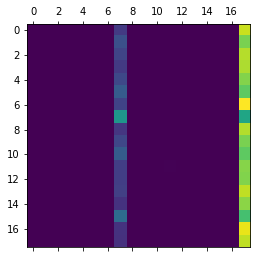

In [ ]:
plt.matshow(confusion_matrixs[0])

In [ ]:
#pickle.dump(model,open('PA.pkl', 'wb'))

Now, we will code the API for the model using flask framework

In [14]:
!pip install tashaphyne

     |████████████████████████████████| 251 kB 13.3 MB/s 
     |████████████████████████████████| 126 kB 11.1 MB/s 


In [15]:
!pip install pyarabic

In [16]:
!pip install emoji 

     |████████████████████████████████| 175 kB 12.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=5163e285f3e2b1e266008268532443735964544337508cef68fd4d14810e5f41
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [18]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [22]:
#Cleaning data

from nltk.corpus import stopwords
from textblob import TextBlob
from tashaphyne.stemming import ArabicLightStemmer
#from nltk.stem.isri import ISRIStemmer
import pyarabic.araby as araby
import re
import emoji


stops = set(stopwords.words("arabic"))
stop_word_comp = {"،","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل","أقل","أكثر","ألا","أم","أما","أمامك","أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك","أولئكم","أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى","إليكم","إليكما","إليكنّ","إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه","إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ","اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة","ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان","الاول","الاولى","التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين","اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه","انها","او","اول","اي","ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع","بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما","بماذا","بمن","بن","بنا","به","بها","بي","بيد","بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم","تينك","تَيْنِ","تِه","تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب","حم","حوالى","حول","حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات","ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا","ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح","رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا","شبه","شخصا","شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضد","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام","عاما","عامة","عدا","عدة","عدد","عدم","عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن","عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو","فى","في","فيم","فيما","فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا","كذلك","كرب","كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف","كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى","لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي","لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ","لَسْتُ","لَسْتُم","لَسْتُمَا","لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام","ماذا","مازال","مافتئ","مايو","متى","مثل","مذ","مساء","مع","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك","مليار","مليون","مما","ممن","من","منذ","منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية","نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا","هل","هلمَّ","هلّا","هم","هما","هن","هنا","هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ","هَذِه","هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت","وقد","وقف","وكان","وكانت","ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","ّأيّان"}
ArListem = ArabicLightStemmer()

def stem(text):
    zen = TextBlob(text)
    words = zen.words
    cleaned = list()
    for w in words:
        ArListem.light_stem(w)
        cleaned.append(ArListem.get_root())
    return " ".join(cleaned)

def remove_stop_words(text):
    zen = TextBlob(text)
    words = zen.words
    return " ".join([w for w in words if not w in stops and not w in stop_word_comp and len(w) >= 2])


def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)

def extract_hashtag(text):
    
    hash_list = ([re.sub(r"(\W+)$", "", i) for i in text.split() if i.startswith("#")])
    word_list = []
    for word in hash_list :
        word_list.extend(split_hashtag_to_words(word))
    return word_list

def split_hashtag_to_words(tag):
    tag = tag.replace('#','')
    tags = tag.split('_')
    if len(tags) > 1 :
        
        return tags
    pattern = re.compile(r"[A-Z][a-z]+|\d+|[A-Z]+(?![a-z])")
    return pattern.findall(tag)

def clean_hashtag(text):
    words = text.split()
    text = list()
    for word in words:
        if is_hashtag(word):
            text.extend(extract_hashtag(word))
        else:
            text.append(word)
    return " ".join(text)

def is_hashtag(word):
    if word.startswith("#"):
        return True
    else:
        return False
    
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U00002700-\U000027BF"  # Dingbats
                                   u"\U00002600-\U000026FF"  # Miscellaneous Symbols
                                   u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                   u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                   "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = emoji.demojize(text)
    return text
  
def clean_tweet(text):
    text = re.sub('#\d+K\d+', ' ', text)  # years like 2K19
    text = re.sub('http\S+\s*', ' ', text)  # remove URLs
    text = re.sub('RT|cc', ' ', text)  # remove RT and cc
    text = re.sub('@[^\s]+',' ',text)
    text = clean_hashtag(text)
    text = remove_emoji(text)
    return text


    
def clean_text (text):
    ## Clean for tweets
    text = clean_tweet(text)
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)  # remove punctuation
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)  
    ## Remove stop words
    text = remove_stop_words(text)
    ## Remove numbers
    text = re.sub("\d+", " ", text)
    ## Remove Tashkeel
    text = normalizeArabic(text)
    
    text = re.sub('[A-Za-z]+',' ',text)
    
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)  
    #Stemming may it is not important in the task!, for chractrize the dialects.
    #text = stem(text)
    return text

In [24]:
!pip install flask-ngrok

In [26]:
def get_PA ():
    PA = pickle.load(open('/content/drive/MyDrive/PA.pkl', 'rb'))
    return PA

In [27]:
def load_embedding ():
    vec = pickle.load(open('/content/drive/MyDrive/vectorizer.pkl', 'rb'))
    return vec

In [33]:
def reduce (copus , vec):
    X = vec.transform(copus)
    X = coo_matrix(X)
    tensor_X = torch.sparse_coo_tensor([X.row , X.col],X.data , dtype = torch.float)
    reducer = MLP(2,tensor_X.shape[1],1000,10000)
    reducer.apply(init_weights)
    Z = reducer(tensor_X)
    Z = Z.detach().numpy()
    return Z

In [41]:
labels = {'IQ': 0, 'LY': 1, 'QA': 2, 'PL': 3, 'SY': 4
          , 'TN': 5, 'JO': 6, 'MA': 7, 'SA': 8, 'YE': 9, 'DZ': 10, 'EG': 11,
          'LB': 12, 'KW': 13, 'OM': 14, 'SD': 15, 'AE': 16, 'BH': 17}
langs = {v:k for k,v in labels.items()}

In [45]:
from flask import Flask, jsonify, request
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

@app.route("/" , methods = ['POST'])
def PA():
  data = request.json
  copus = [clean_text(text) for text in data]
  vec = load_embedding()
  emb = reduce(copus , vec)
  PA_ML = get_PA()
  labels = PA_ML.predict(emb)
  out = [langs[l] for l in labels]
  return jsonify(out)

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://bef7-35-204-212-163.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
127.0.0.1 - - [10/Mar/2022 09:56:53] "POST / HTTP/1.1" 200 -
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_p